<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 非線形回帰ー実践編

In [ ]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import statsmodels.api as sma

エイムズの住宅販売価格予測を、非線形回帰を使って行っていきます。

欠損値の処理などは線形回帰の時と同じとします。

## 欠損値の処理

In [ ]:
# Ames housing datasetを取得し、as_frame=Trueを指定してDataFrame形式で読み込む
housing = fetch_openml(name="house_prices", as_frame=True)

# DataFrameを表示
df = housing.frame

# 欠損値に意味がある場合の処理
df["PoolQC"] = df["PoolQC"].fillna("NA")
df["MiscFeature"] = df["MiscFeature"].fillna("NA")
df["Alley"] = df["Alley"].fillna("NA")
df["Fence"] = df["Fence"].fillna("NA")
df["FireplaceQu"] = df["FireplaceQu"].fillna("NA")
df["GarageFinish"] = df["GarageFinish"].fillna("NA")
df["GarageQual"] = df["GarageQual"].fillna("NA")
df["GarageCond"] = df["GarageCond"].fillna("NA")
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(0)
df["GarageType"] = df["GarageType"].fillna("NA")
df["BsmtExposure"] = df["BsmtExposure"].fillna("NA")
df["BsmtCond"] = df["BsmtCond"].fillna("NA")
df["BsmtQual"] = df["BsmtQual"].fillna("NA")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna("NA")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NA")

# NeighbourhoodごとにLotFrontageの中央値を算出
platform_neighbourhood_dict = df.groupby("Neighborhood").median()["LotFrontage"].to_dict()
# 同じ地区の中央値の値で埋める
df["LotFrontage"] = df.apply(
    lambda row: platform_neighbourhood_dict[row["Neighborhood"]]
    if np.isnan(row["LotFrontage"])
    else row["LotFrontage"],
    axis=1
)

# 欠損値の数を計算
chk_null2 = df.isnull().sum()

# 欠損値の割合を計算
chk_null_pct2 = chk_null2 / (df.index.max() + 1)

# 欠損値の数と割合がゼロでない列を抽出し、欠損値テーブルを作成
chk_null_tbl2 = pd.concat([chk_null2[chk_null2 > 0], chk_null_pct2[chk_null_pct2 > 0]], axis=1)

# 欠損値の割合を基準にテーブルを降順でソートし、列名を変更
chk_null_tbl_new = chk_null_tbl2.sort_values(by=1, ascending=False).rename(columns={0: "欠損レコード数", 1: "欠損割合"})

"""
"MasVnrArea	"カラム（組積造の面積）は
数値型なので中央値で欠損値処理
"MasVnrType"カラム（組積造の種別）と"Electrical"カラム（電気システムの種類）は
名義型なので最頻値で欠損値処理
"""

# 欠損値の数を計算し、0以外のカラムのインデックスを抽出
nonzero_columns = chk_null_tbl_new.index

# 欠損値を埋める処理
for column in nonzero_columns:
    if np.issubdtype(df[column].dtype, np.number):
        # 数値型の場合は中央値で埋める
        df[column].fillna(df[column].median(), inplace=True)
    else:
        # 文字型の場合は最頻値で埋める
        df[column].fillna(df[column].mode()[0], inplace=True)

# データ型を適切なタイプに変換
df['YrSold'] = df['YrSold'].astype(str)  # 売れた年
df['MoSold'] = df['MoSold'].astype(str)  # 売れた月
df['GarageYrBlt'] = df['GarageYrBlt'].astype(str)  # ガレージが建てられた年
df['YearBuilt'] = df['YearBuilt'].astype(str)  # 建築された年
df['YearRemodAdd'] = df['YearRemodAdd'].astype(str)  # リフォームされた年
df['MSSubClass'] = df['MSSubClass'].astype(str)  # 建物クラス（建てられ方の違い）

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
<ipython-input-2-b15dfc9397c0>:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  platform_neighbourhood_dict = df.groupby("Neighborhood").median()["LotFrontage"].to_dict()


In [ ]:
# 欠損値の数を計算
chk_null3 = df.isnull().sum()

# 欠損値の割合を計算
chk_null_pct3 = chk_null3 / (df.index.max() + 1)

# 欠損値の数と割合がゼロでない列を抽出し、欠損値テーブルを作成
chk_null_tbl3 = pd.concat([chk_null3[chk_null3 > 0], chk_null_pct3[chk_null_pct3 > 0]], axis=1)

# 欠損値の割合を基準にテーブルを降順でソートし、列名を変更
chk_null_tbl_end = chk_null_tbl3.sort_values(by=1, ascending=False).rename(columns={0: "欠損レコード数", 1: "欠損割合"})
chk_null_tbl_end

,欠損レコード数,欠損割合


すべての欠損値を埋めることができました。

## そのほかのデータの加工

ヒノマルクさんの記事群(リンクは[こちら](https://www.hinomaruc.com/tag/ames/?order=asc))にもありますが、  
ほかにも以下のような加工をすることで、モデルの精度向上が期待できます。



- 外れ値処理

  - 外れ値かどうかを判断して除外するかどうかを検討する。

- 特徴量エンジニアリング

  - 新しい意味を持つ変数を作成する。
  - より説明力がある変数が作成できたり、変数の数を減らせる可能性がある。
  
- 変数選択

  - モデリングに必要なさそうな変数は除外する。
  - 計算量を減らせたり多重共線性を防げる可能性がある。

ヒノマルクさんの[こちら](https://www.hinomaruc.com/ames-dataset-analytics-3-1/)の記事を参考にしました。

## 住宅価格を多項式回帰で予測

いよいよ住宅価格の予測に入ります。  
使用するカラムもここでは線形回帰と同じものを使います。

<ipython-input-4-b653b37b010e>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(new_df.corr(), annot=True, cmap='YlGnBu', linewidths=0.5)


<Axes: >

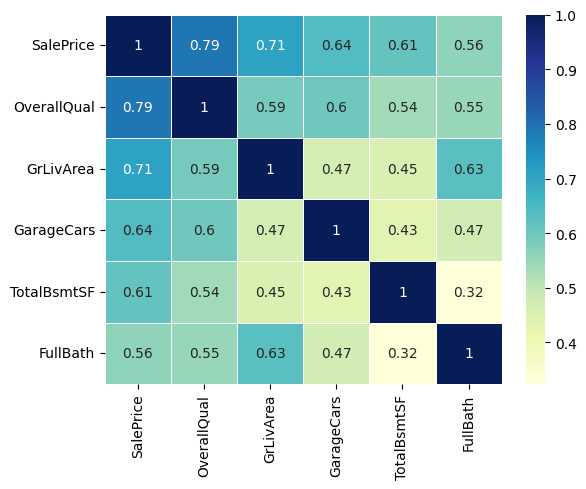

In [ ]:
selected_columns = [
    "SalePrice",  # 住宅価格
    "OverallQual",  #  住居の品質
    "GrLivArea",  # 地上全ての住宅面積
    "GarageCars",  # ガレージへの駐車可能台数
    "TotalBsmtSF",  # 全地下室の面積
    "FullBath",  # フル・バスルームの数（地下室は除く）
    "YearBuilt"  #  建築された年
]

new_df = df[selected_columns]

sns.heatmap(new_df.corr(), annot=True, cmap='YlGnBu', linewidths=0.5)

ここでは、**`degree=2`**の多項式回帰を行います。

また、汎化性能を測る方法として、**Repeated 5-Fold CV**を用います。

In [ ]:
# 目的変数に"SalePrice"、説明変数にそれ以外の6つのカラムを指定
X = new_df.drop('SalePrice', axis=1)
y = new_df['SalePrice']

# データを5つのグループに分ける
k = 5

# 3回グループ分けを行う
n_repeats = 3

# 15回学習を行う
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)

# Pipelineを定義
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # データの標準化
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),  # 多項式特徴量の生成
    ('model', LinearRegression())  # 線形回帰モデル
])

# 15回分決定係数を求める
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')

# 決定係数の平均と標準偏差を求める
print(f"R2({k}FoldCV): {np.mean(scores)}")
print(f"std: {np.std(scores)}")

R2(5FoldCV): 0.7888161980362526
std: 0.16428582313609885


線形回帰のときは決定係数は以下のような結果となっていたので、  
標準偏差が大きいことが少し気になりますが、精度の向上が確認できます。

![](https://imgur.com/YckFZSU.png)

## 住宅価格をknn回帰で予測

ここでは、**`k=10`**のknn回帰を行います。

また、汎化性能を測る方法として、**Repeated 5-Fold CV**を用います。

In [ ]:
# 目的変数に"SalePrice"、説明変数にそれ以外の6つのカラムを指定
X = new_df.drop('SalePrice', axis=1)
y = new_df['SalePrice']

# データを5つのグループに分ける
k = 5

# 3回グループ分けを行う
n_repeats = 3

# 15回学習を行う
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)

# Pipelineを定義
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # データの標準化
    ('model', KNeighborsRegressor(n_neighbors=10))  # knn回帰モデル
])

# 15回分決定係数を求める
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')

# 決定係数の平均と標準偏差を求める
print(f"R2({k}FoldCV): {np.mean(scores)}")
print(f"std: {np.std(scores)}")

R2(5FoldCV): 0.8093369557827802
std: 0.04518050738311932


線形回帰のときは決定係数は以下のような結果となっていたので、  
精度の向上が確認できます。

![](https://imgur.com/YckFZSU.png)